# Imports and Installing

In [2]:
#!pip install mlxtend;
#!pip install git+https://github.com/nickkunz/smogn.git;
#!pip install fitter;
#!pip install tensorflow;

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
import smogn
from scipy.optimize import curve_fit
from fitter import Fitter
import scipy.stats as stats
from scipy import stats as sps
import mlxtend
import math
%matplotlib inline

# Data Preprocessing

In [4]:
# get data
df = pd.read_csv('Medical_insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# number of instances and features of the data
df.shape

(2772, 7)

In [6]:
# information on the data type of the instances and features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [7]:
# basic descriptive information on feature data
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
# counts the number of duplicate instances in data
df.duplicated().sum()

1435

In [9]:
# removes the duplicate instances in data, there are none in this case but we do it to show
df.drop_duplicates(inplace = True)

In [10]:
# check for null values in data
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
# drop null values in data
df = df.dropna()

## Data Enigneering

In [13]:
engineered_data = df.copy()
engineered_data['age_times_log_charges'] = np.log(engineered_data['charges'] * engineered_data['age'] )
engineered_data.head()

,age,sex,bmi,children,smoker,region,charges,age_times_log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,12.678615
1,18,male,33.770,1,no,southeast,1725.55230,10.343674
2,28,male,33.000,3,no,southeast,4449.46200,11.732743
3,33,male,22.705,0,no,northwest,21984.47061,13.494599
4,32,male,28.880,0,no,northwest,3866.85520,11.725933


## Data visualization

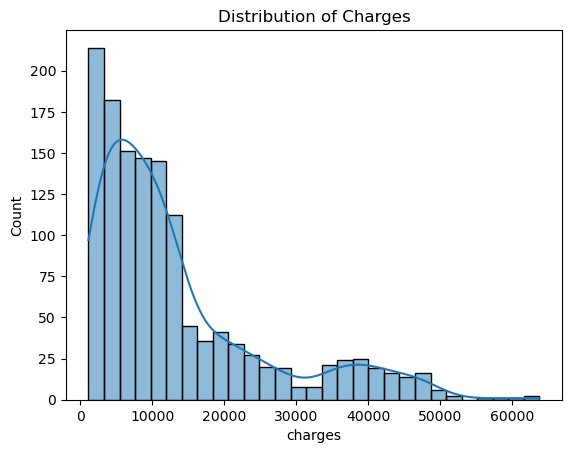

In [15]:
sns.histplot(df['charges'], kde = True)
plt.title('Distribution of Charges')
plt.show()

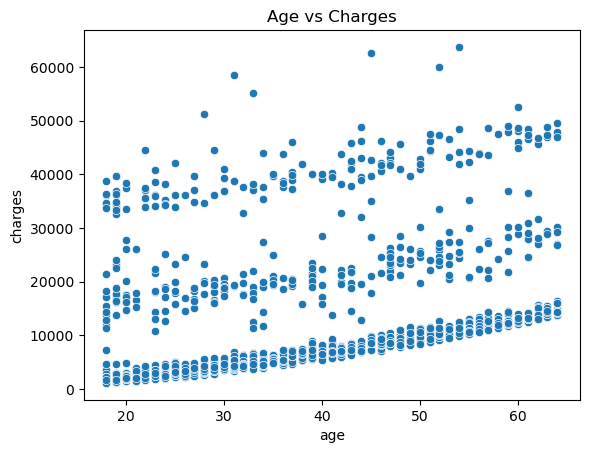

In [16]:
# Visualize the relationship between prices and area (can be replaced by any two features)

sns.scatterplot(x = 'age', y = 'charges', data = df)
plt.title('Age vs Charges')
plt.show()

In [17]:
# Converting chategorical features to numerical using the one-hot encoding method
numerical_data = pd.get_dummies(df, columns = ['smoker','sex','region'], drop_first = True)
numerical_data.head()

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,False,True,False
2,28,33.000,3,4449.46200,False,True,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False


## Data prepatation for Machine Learning

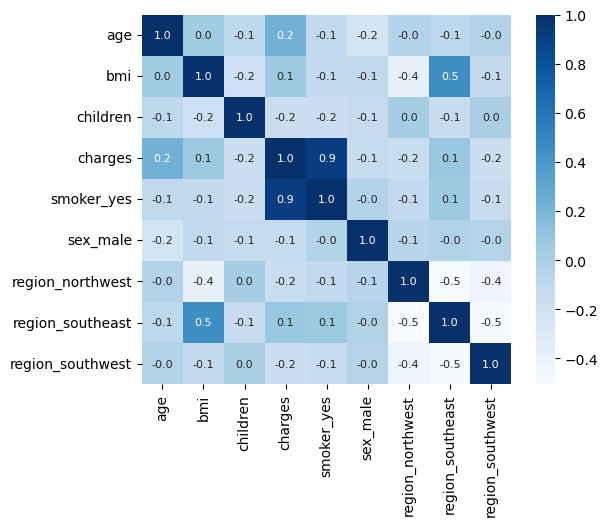

(1337, 7)

In [19]:
correlation = numerical_data.corr()
sns.heatmap(correlation.corr(), cbar = True, square = True, fmt = '.1f', annot = True, annot_kws = {'size': 8}, cmap = 'Blues')
plt.show()
df.shape

### Separate training set, validation set and test set.

In [21]:
# separate training set and test set.
train_df_1, test_data = train_test_split(numerical_data, test_size=0.2, random_state=42)

# Separate features and target in the test data
x_test = test_data.drop(columns=['charges'])
y_test = test_data['charges']

# Separate features and target in the training data
x_train_1 = train_df_1.drop(columns=['charges'])
y_train_1 = train_df_1['charges']

# Separate validation from training data
train_df_2, validation_data_1 = train_test_split(train_df_1, test_size=0.2, random_state=42)

# Separate features and target in the validation data
x_valid_1 = validation_data_1.drop(columns=['charges'])
y_valid_1 = validation_data_1['charges']

# Separate features and target in the new training data
x_train_2 = train_df_2.drop(columns=['charges'])
y_train_2 = train_df_2['charges']

## Oversampling method

### Method 1 - Simple Bootstrapping or Oversampling

In [24]:
RandState = 42
train_bootstrapping = resample(train_df_1, replace=True, n_samples=2500, random_state=RandState) # if n_samples is set to 5000 it RFR and GBR hyp. search overfits

# Separate features and target in the training data (oversampled data)
x_train_3 = train_bootstrapping.drop(columns=['charges'])
y_train_3 = train_bootstrapping['charges']

# Separate validation from training data
train_df_3, validation_data_2 = train_test_split(train_bootstrapping, test_size=0.2, random_state=42)

# Separate features and target in the validation data
x_valid_2 = validation_data_2.drop(columns=['charges'])
y_valid_2 = validation_data_2['charges']

# Separate features and target in the new training data
x_train_4 = train_df_3.drop(columns=['charges'])
y_train_4 = train_df_3['charges']

# Regression Models 

## Linear regression

### First case - using base data for training

#### Base case - predicting using the default hyperparameters

In [29]:
#base case
param_grid = {
    "fit_intercept": [True],
    "copy_X": [True],
    "n_jobs": [None],
    "positive": [False]
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Default Parameters:", grid_search.best_params_)

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best1 = best_lr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best1)
r2_best = r2_score(y_test, y_pred_best1)

print(f"Results of the Base Case:")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Default Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Results of the Base Case:
Optimized Validation Mean Squared Error: 35478020.68
Optimized Validation Root Mean Squared Error: 5956.34
Optimized Validation R² Score: 0.81


##### Plot Evaluation Linear Regression

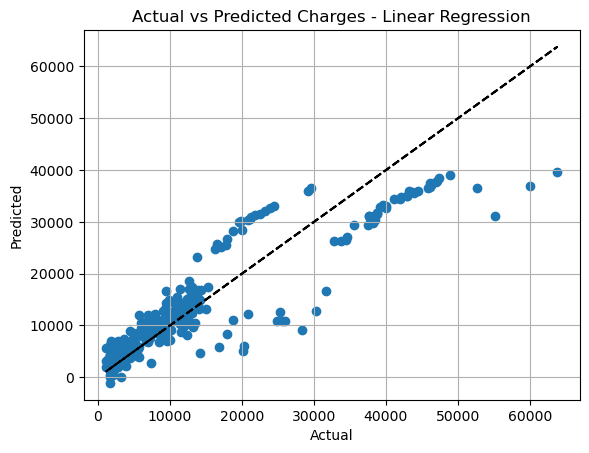

In [31]:
# Scatter plot showing Actual vs Predicted

plt.scatter(y_test, y_pred_best1)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Linear Regression')
plt.grid()
plt.show()

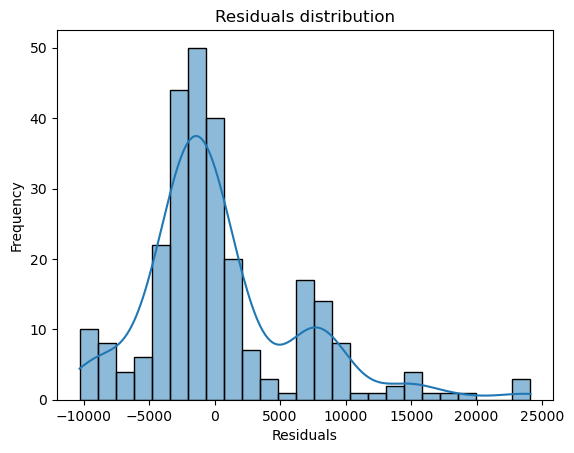

In [32]:
# Visualize residuals
residuals = y_test - y_pred_best1

sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

#### HyperParameter searching using validation data for testing

In [34]:
param_grid = {
    "fit_intercept": [True, False],
    "copy_X": [True, False],
    "n_jobs": [True, False],
    "positive": [True, False]
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_2, y_train_2)

# Print best parameters
print("Best Parameters with Optimization:", grid_search.best_params_)

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best = best_lr.predict(x_valid_1)

mse_best = mean_squared_error(y_valid_1, y_pred_best)
r2_best = r2_score(y_valid_1, y_pred_best)

print(f"Best results from testing on Validation set:")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Best Parameters with Optimization: {'copy_X': True, 'fit_intercept': True, 'n_jobs': True, 'positive': True}
Best results from testing on Validation set:
Optimized Validation Mean Squared Error: 34292117.34
Optimized Validation Root Mean Squared Error: 5855.95
Optimized Validation R² Score: 0.73


#### Using found HyperParameters conduct search using the training + validation data to train

In [36]:
param_grid = {
    "fit_intercept": [True], # fill in parameter from previous part
    "copy_X": [True], # fill in parameter from previous part
    "n_jobs": [None], # fill in parameter from previous part
    "positive": [False] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Using the parameters:", grid_search.best_params_) # should be the same as found in previous step

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best3 = best_lr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best3)
r2_best = r2_score(y_test, y_pred_best3)

print(f"Results using the optimized HyperParameters on training + validation set")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Using the parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Results using the optimized HyperParameters on training + validation set
Optimized Validation Mean Squared Error: 35478020.68
Optimized Validation Root Mean Squared Error: 5956.34
Optimized Validation R² Score: 0.81


### Second case - using bootstrapped data for training

#### Base case - predicting using the default hyperparameters on the bootstrapped data

In [39]:
#base case
param_grid = {
    "fit_intercept": [True],
    "copy_X": [True],
    "n_jobs": [None],
    "positive": [False]
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Base Parameters:", grid_search.best_params_)

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best_boot = best_lr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best_boot)
r2_best = r2_score(y_test, y_pred_best_boot)

print(f"Results of the Base Case:")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Base Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Results of the Base Case:
Optimized Validation Mean Squared Error: 36148654.02
Optimized Validation Root Mean Squared Error: 6012.38
Optimized Validation R² Score: 0.80


##### *******Statistical Testing to see test if there is difference when sampling (comparing LR base case default hyperparametres vs. LR base case default hyperparameters bootstrapped)

In [41]:
# Compute residuals
residuals_base = y_test - y_pred_best1.ravel()
residuals_optimized = y_test - y_pred_best_boot.ravel()

# Define hypotheses
null_hypothesis = "The resampling has no effect on prediction errors."
alternate_hypothesis = "The resampling significantly reduces prediction errors."

# Significance level
alpha = 0.05

# Paired t-test (absolute residuals to compare error magnitudes)
t_statistic, p_value = stats.ttest_rel(np.abs(residuals_optimized), np.abs(residuals_base))

# Manual computation of t-statistic
m = np.mean(np.abs(residuals_optimized) - np.abs(residuals_base))
s = np.std(np.abs(residuals_optimized) - np.abs(residuals_base), ddof=1)
n = len(residuals_base)
t_statistic_manual = m / (s / np.sqrt(n))

# Decision
decision = "Reject" if p_value <= alpha else "Fail to reject"

if decision == "Reject":
    conclusion = "There is statistically significant evidence that the optimized model has lower prediction errors."
else:
    conclusion = "There is insufficient evidence to claim a significant improvement in prediction errors."

# Print results
print("T-statistic (from scipy):", t_statistic)
print("P-value (from scipy):", p_value)
print("T-statistic (calculated manually):", t_statistic_manual)
print(f"Decision: {decision} the null hypothesis at alpha={alpha}.")
print("Conclusion:", conclusion)


T-statistic (from scipy): -0.021348636795209347
P-value (from scipy): 0.982983491443636
T-statistic (calculated manually): -0.021348636795209344
Decision: Fail to reject the null hypothesis at alpha=0.05.
Conclusion: There is insufficient evidence to claim a significant improvement in prediction errors.


#### HyperParameter searching using validation data for testing on bootstrapped data

In [43]:
param_grid = {
    "fit_intercept": [True, False],
    "copy_X": [True, False],
    "n_jobs": [True, False],
    "positive": [True, False]
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_4, y_train_4)

# Print best parameters
print("Best Parameters with Optimization:", grid_search.best_params_)

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best = best_lr.predict(x_valid_2)

mse_best = mean_squared_error(y_valid_2, y_pred_best)
r2_best = r2_score(y_valid_2, y_pred_best)

print(f"Best results from testing on Validation set of the bootstrapped training data:")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Best Parameters with Optimization: {'copy_X': True, 'fit_intercept': True, 'n_jobs': True, 'positive': True}
Best results from testing on Validation set of the bootstrapped training data:
Optimized Validation Mean Squared Error: 37252396.48
Optimized Validation Root Mean Squared Error: 6103.47
Optimized Validation R² Score: 0.75


#### Using found HyperParameters conduct search using the training + validation data to train

In [45]:
param_grid = {
    "fit_intercept": [True], # fill in parameter from previous part
    "copy_X": [True], # fill in parameter from previous part
    "n_jobs": [None], # fill in parameter from previous part
    "positive": [False] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Using the parameters:", grid_search.best_params_) # should be the same as found in previous step

# Train best model
best_lr = grid_search.best_estimator_
y_pred_best = best_lr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results using the optimized HyperParameters on Test set")
print(f"Optimized Validation Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Validation Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized Validation R² Score: {r2_best:.2f}")

Using the parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Results using the optimized HyperParameters on Test set
Optimized Validation Mean Squared Error: 36148654.02
Optimized Validation Root Mean Squared Error: 6012.38
Optimized Validation R² Score: 0.80


## Random Forest Regression

### First Case - Analysis using the base data

#### Base case - predicting using the default hyperparameters

In [49]:
param_grid = {
    "n_estimators": [100],
    "criterion": ['squared_error'],
    "min_samples_split": [2]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Default Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results of the Base Case:")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Default Parameters: {'criterion': 'squared_error', 'min_samples_split': 2, 'n_estimators': 100}
Results of the Base Case:
Optimized Mean Squared Error: 22335596.68
Optimized Root Mean Squared Error: 4726.06
Optimized R² Score: 0.88


##### Plot Evaluation Random Forest

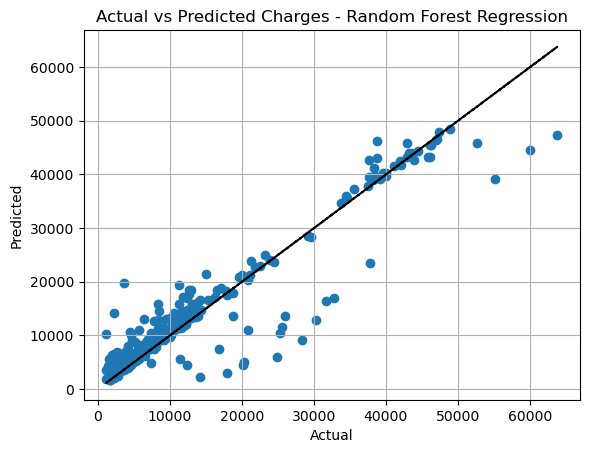

In [51]:
# Scatter plot showing Actual vs Predicted

plt.scatter(y_test, y_pred_best)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Random Forest Regression')
plt.grid()
plt.show()

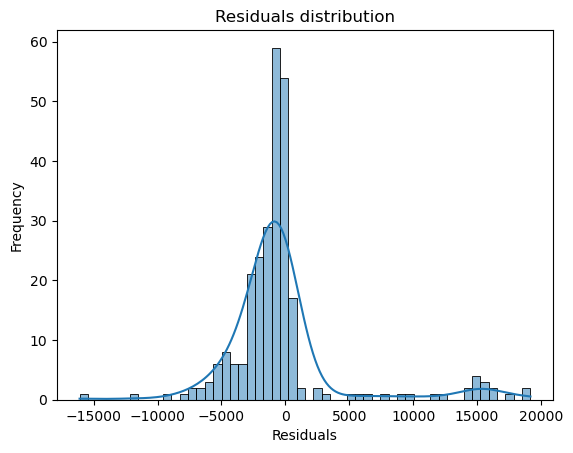

In [52]:
# Visualize residuals
residuals = y_test - y_pred_best

sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

#### HyperParameter searching using validation data for testing

In [54]:
param_grid = {
    "n_estimators": [90, 100, 110],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "min_samples_split": [2, 3, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_2, y_train_2)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_valid_1)

mse_best = mean_squared_error(y_valid_1, y_pred_best)
r2_best = r2_score(y_valid_1, y_pred_best)

print(f"Results using the optimized HyperParameters on Validation set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'criterion': 'poisson', 'min_samples_split': 4, 'n_estimators': 110}
Results using the optimized HyperParameters on Validation set
Optimized Mean Squared Error: 24923552.82
Optimized Root Mean Squared Error: 4992.35
Optimized R² Score: 0.80


#### Using found HyperParameters conduct search using the training + validation data to train

In [56]:
param_grid = {
    "n_estimators": [110], # fill in parameter from previous part
    "criterion": ['poisson'], # fill in parameter from previous part
    "min_samples_split": [4] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results using the optimized HyperParameters on Training + Validation set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'criterion': 'poisson', 'min_samples_split': 4, 'n_estimators': 110}
Results using the optimized HyperParameters on Training + Validation set
Optimized Mean Squared Error: 21286781.93
Optimized Root Mean Squared Error: 4613.76
Optimized R² Score: 0.88


### Second case - using bootstrapped data for training

#### Base case - predicting using the default hyperparameters on the bootstrapped data

In [59]:
param_grid = {
    "n_estimators": [100],
    "criterion": ['squared_error'],
    "min_samples_split": [3]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Default Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results of the Default HyperParameters using bootstrapped training data")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Default Parameters: {'criterion': 'squared_error', 'min_samples_split': 3, 'n_estimators': 100}
Results of the Default HyperParameters using bootstrapped training data
Optimized Mean Squared Error: 24891002.87
Optimized Root Mean Squared Error: 4989.09
Optimized R² Score: 0.86


#### HyperParameter searching using validation data for testing on bootstrapped data

In [61]:
param_grid = {
    "n_estimators": [90, 100, 110],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "min_samples_split": [2, 3, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_4, y_train_4)
print(x_train_4.shape)
# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_valid_2)

mse_best = mean_squared_error(y_valid_2, y_pred_best)
r2_best = r2_score(y_valid_2, y_pred_best)

print(f"Best results from testing on Validation set of the bootstrapped training data")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

(2000, 8)
Best Parameters: {'criterion': 'squared_error', 'min_samples_split': 2, 'n_estimators': 90}
Best results from testing on Validation set of the bootstrapped training data
Optimized Mean Squared Error: 10012542.17
Optimized Root Mean Squared Error: 3164.26
Optimized R² Score: 0.93


#### Using found HyperParameters conduct search using the training + validation bootstrapped data to train

In [63]:
param_grid = {
    "n_estimators": [100], # fill in parameter from previous part
    "criterion": ['friedman_mse'], # fill in parameter from previous part
    "min_samples_split": [3] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rfr = grid_search.best_estimator_
y_pred_best = best_rfr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results using the optimized HyperParameters on Training + Validation bootstrapped data set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'criterion': 'friedman_mse', 'min_samples_split': 3, 'n_estimators': 100}
Results using the optimized HyperParameters on Training + Validation bootstrapped data set
Optimized Mean Squared Error: 24848159.46
Optimized Root Mean Squared Error: 4984.79
Optimized R² Score: 0.86


## Gradient Bosting Regression

### First Case - Analysis using the base data

#### Base case - predicting using the default hyperparameters

In [67]:
param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3]
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results of the Default Case")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Results of the Default Case
Optimized Mean Squared Error: 18218022.15
Optimized Root Mean Squared Error: 4268.26
Optimized R² Score: 0.90


##### Plot Evaluation Gradient Boosting

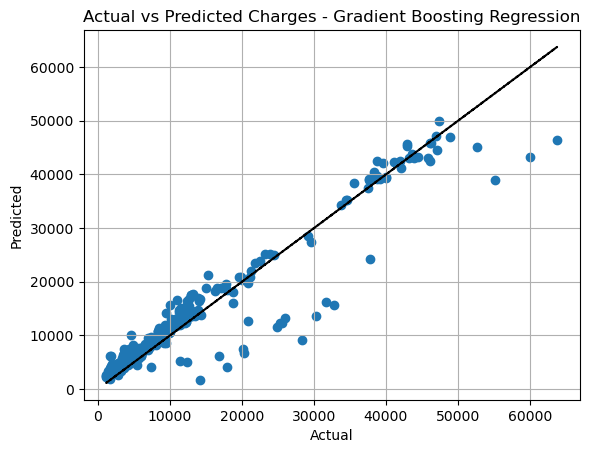

In [69]:
# Scatter plot showing Actual vs Predicted

plt.scatter(y_test, y_pred_best)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Gradient Boosting Regression')
plt.grid()
plt.show()

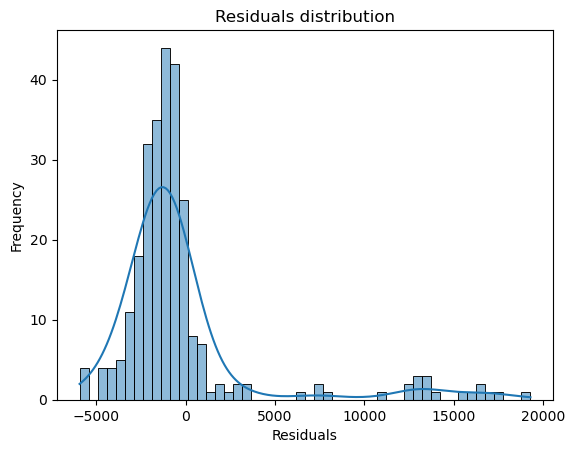

In [70]:
# Visualize residuals
residuals = y_test - y_pred_best

sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

#### HyperParameter searching using validation data for testing

In [72]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5]
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_2, y_train_2)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_valid_1)

mse_best = mean_squared_error(y_valid_1, y_pred_best)
r2_best = r2_score(y_valid_1, y_pred_best)

print(f"Best results from testing on Validation set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best results from testing on Validation set
Optimized Mean Squared Error: 22562445.92
Optimized Root Mean Squared Error: 4749.99
Optimized R² Score: 0.82


#### Using found HyperParameters conduct search using the training + validation data to train

In [74]:
param_grid = {
    "n_estimators": [100], # fill in parameter from previous part
    "learning_rate": [0.1], # fill in parameter from previous part
    "max_depth": [3] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_1, y_train_1)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_valid_2)

mse_best = mean_squared_error(y_valid_2, y_pred_best)
r2_best = r2_score(y_valid_2, y_pred_best)

print(f"Results using the optimized HyperParameters on Training + Validation set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Results using the optimized HyperParameters on Training + Validation set
Optimized Mean Squared Error: 12827756.40
Optimized Root Mean Squared Error: 3581.59
Optimized R² Score: 0.91


### Second case - using bootstrapped data for training

#### Base case - predicting using the default hyperparameters on the bootstrapped data

In [77]:
param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3]
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results of the Default HyperParameters using bootstrapped training data")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Results of the Default HyperParameters using bootstrapped training data
Optimized Mean Squared Error: 18435887.25
Optimized Root Mean Squared Error: 4293.70
Optimized R² Score: 0.90


#### HyperParameter searching using validation data for testing on bootstrapped data

In [79]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5]
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_4, y_train_4)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_valid_2)

mse_best = mean_squared_error(y_valid_2, y_pred_best)
r2_best = r2_score(y_valid_2, y_pred_best)

print(f"Best results from testing on Validation set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best results from testing on Validation set
Optimized Mean Squared Error: 11861328.94
Optimized Root Mean Squared Error: 3444.03
Optimized R² Score: 0.92


#### Using found HyperParameters conduct search using the training + validation bootstrapped data to train

In [81]:
param_grid = {
    "n_estimators": [300], # fill in parameter from previous part
    "learning_rate": [0.2], # fill in parameter from previous part
    "max_depth": [5] # fill in parameter from previous part
}

# Perform Grid Search
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(x_train_3, y_train_3)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(x_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Results using the optimized HyperParameters on Training + Validation bootstrapped data set")
print(f"Optimized Mean Squared Error: {mse_best:.2f}")
print(f"Optimized Root Mean Squared Error: {math.sqrt(mse_best):.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Results using the optimized HyperParameters on Training + Validation bootstrapped data set
Optimized Mean Squared Error: 25570710.24
Optimized Root Mean Squared Error: 5056.75
Optimized R² Score: 0.86


# Neural Network

## Neural Network type feedforward

### Instantiate the neural network model

In [85]:
NN = MLPRegressor(max_iter = 300, activation = "relu", hidden_layer_sizes = (200,200))

### First case - Analysis using the base data

In [87]:
# Fit/train
NN.fit(x_train_1, y_train_1)

# Predict using test input data
NN_pred1 = NN.predict(x_test)
r2 = r2_score(y_test, NN_pred1)

# Compute error
print("MSE:", mean_squared_error(y_test,NN_pred1))
print("MAE:", mean_absolute_error(y_test,NN_pred1))
print("MAE:", mean_absolute_error(y_test,NN_pred1))
print("R^2:", r2)

MSE: 84480622.10344663
MAE: 6545.813734709453
MAE: 6545.813734709453
R^2: 0.5402566846199346


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Second case = Analysis using the bootstrapped data

In [89]:
# Fit/train
NN.fit(x_train_3, y_train_3)

# Predict using test input data
NN_pred2 = NN.predict(x_test)
r2 = r2_score(y_test, NN_pred2)

# Compute error
print("MSE:", mean_squared_error(y_test,NN_pred2))
print("MAE:", mean_absolute_error(y_test,NN_pred2))
print("MAE:", mean_absolute_error(y_test,NN_pred2))
print("R^2:", r2)

MSE: 34987905.232129894
MAE: 3706.794777010324
MAE: 3706.794777010324
R^2: 0.8095959150262143


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Statistical methods

In [91]:
# Compute residuals
residuals_base = y_test - NN_pred1.ravel()
residuals_optimized = y_test - NN_pred2.ravel()

# Define hypotheses
null_hypothesis = "The resampling has no effect on prediction errors."
alternate_hypothesis = "The resampling significantly reduces prediction errors."

# Significance level
alpha = 0.05

# Paired t-test (absolute residuals to compare error magnitudes)
t_statistic, p_value = stats.ttest_rel(np.abs(residuals_optimized), np.abs(residuals_base))

# Manual computation of t-statistic
m = np.mean(np.abs(residuals_optimized) - np.abs(residuals_base))
s = np.std(np.abs(residuals_optimized) - np.abs(residuals_base), ddof=1)
n = len(residuals_base)
t_statistic_manual = m / (s / np.sqrt(n))

# Decision
decision = "Reject" if p_value <= alpha else "Fail to reject"

if decision == "Reject":
    conclusion = "There is statistically significant evidence that the bootstrapped model has lower prediction errors."
else:
    conclusion = "There is insufficient evidence to claim a significant improvement in prediction errors."

# Print results
print("T-statistic (from scipy):", t_statistic)
print("P-value (from scipy):", p_value)
print("T-statistic (calculated manually):", t_statistic_manual)
print(f"Decision: {decision} the null hypothesis at alpha={alpha}.")
print("Conclusion:", conclusion)


T-statistic (from scipy): -10.174560277950073
P-value (from scipy): 9.198871568417392e-21
T-statistic (calculated manually): -10.174560277950075
Decision: Reject the null hypothesis at alpha=0.05.
Conclusion: There is statistically significant evidence that the bootstrapped model has lower prediction errors.


### Plot Evaluation

#### No resampling

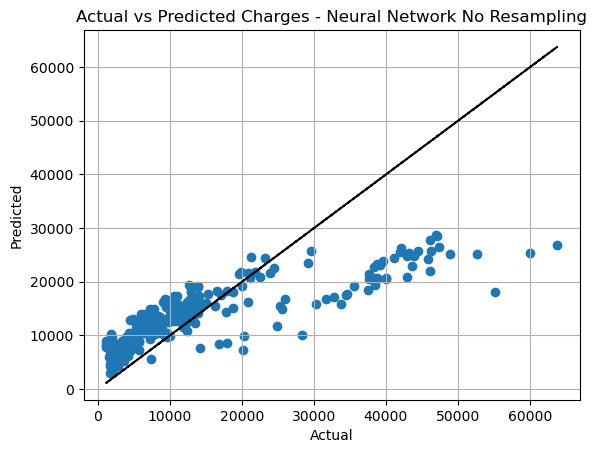

In [94]:
# Scatter plot showing Actual vs Predicted
plt.scatter(y_test, NN_pred1)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Neural Network No Resampling')
plt.grid()
plt.show()

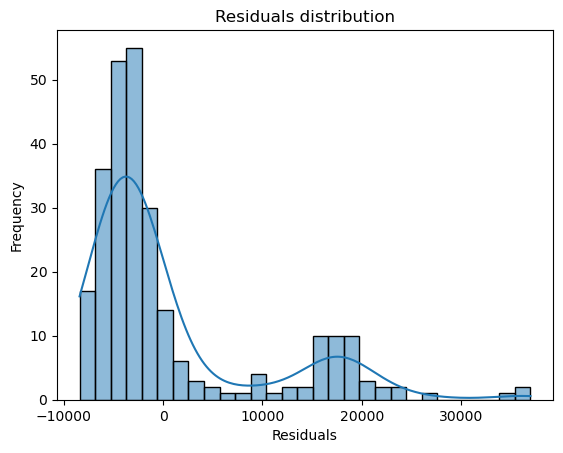

In [95]:
# Visualize residuals
residuals = y_test - NN_pred1.ravel()
sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

#### Bootstrapped

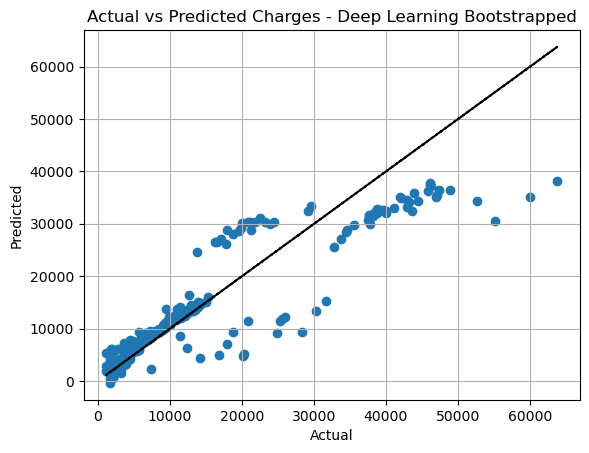

In [97]:
# Scatter plot showing Actual vs Predicted
plt.scatter(y_test, NN_pred2)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Deep Learning Bootstrapped')
plt.grid()
plt.show()

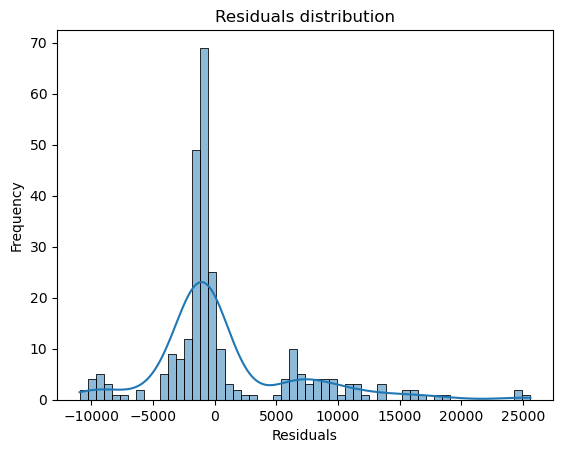

In [98]:
# Visualize residuals
residuals = y_test - NN_pred2.ravel()
sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

# Deep learning

## Deep learning base case

In [101]:
# Build Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=(x_train_1.shape[1],)),  # Input layer
    keras.layers.Dense(32, activation="relu"),  # Hidden layer
    keras.layers.Dense(16, activation="relu"),  # Hidden layer
    keras.layers.Dense(1)  # Output layer (Linear activation for regression)
])

# Compile Model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Model (silent training)
history = model.fit(x_train_1, y_train_1, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

# Predict
y_pred1 = model.predict(x_test, verbose=0)

# Compute Metrics
mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred1)

# Print Results
print(f"Optimized Mean Squared Error: {mse:.2f}")
print(f"Optimized Root Mean Squared Error: {rmse:.2f}")
print(f"Optimized R² Score: {r2:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimized Mean Squared Error: 126086748.40
Optimized Root Mean Squared Error: 11228.84
Optimized R² Score: 0.31


## Deep learning + Bootstrapping¶

In [103]:
# Build Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=(x_train_1.shape[1],)),  # Input layer
    keras.layers.Dense(32, activation="relu"),  # Hidden layer
    keras.layers.Dense(16, activation="relu"),  # Hidden layer
    keras.layers.Dense(1)  # Output layer (Linear activation for regression)
])

# Compile Model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Model (silent training)
history = model.fit(x_train_3, y_train_3, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

# Predict
y_pred2 = model.predict(x_test, verbose=0)

# Compute Metrics
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred2)

# Print Results
print(f"Optimized Mean Squared Error: {mse:.2f}")
print(f"Optimized Root Mean Squared Error: {rmse:.2f}")
print(f"Optimized R² Score: {r2:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimized Mean Squared Error: 35143716.86
Optimized Root Mean Squared Error: 5928.21
Optimized R² Score: 0.81


## Statistical testing

In [105]:
# Compute residuals
residuals_base = y_test - y_pred1.ravel()
residuals_optimized = y_test - y_pred2.ravel()

# Define hypotheses
null_hypothesis = "The resampling has no effect on prediction errors."

# Significance level
alpha = 0.05

# Paired t-test (absolute residuals to compare error magnitudes)
t_statistic, p_value = stats.ttest_rel(np.abs(residuals_optimized), np.abs(residuals_base))

# Manual computation of t-statistic
m = np.mean(np.abs(residuals_optimized) - np.abs(residuals_base))
s = np.std(np.abs(residuals_optimized) - np.abs(residuals_base), ddof=1)
n = len(residuals_base)
t_statistic_manual = m / (s / np.sqrt(n))

# Decision
decision = "Reject" if p_value <= alpha else "Fail to reject"

if decision == "Reject":
    conclusion = "There is statistically significant evidence that the bootsrapped model has lower prediction errors."
else:
    conclusion = "There is insufficient evidence to claim a significant improvement in prediction errors."

# Print results
print("T-statistic (from scipy):", t_statistic)
print("P-value (from scipy):", p_value)
print("T-statistic (calculated manually):", t_statistic_manual)
print(f"Decision: {decision} the null hypothesis at alpha={alpha}.")
print("Conclusion:", conclusion)


T-statistic (from scipy): -13.479634615691266
P-value (from scipy): 6.099356085986866e-32
T-statistic (calculated manually): -13.479634615691264
Decision: Reject the null hypothesis at alpha=0.05.
Conclusion: There is statistically significant evidence that the bootsrapped model has lower prediction errors.


## Evaluation Plot Deep Learning

In [107]:
# first without bootsrapping then with

### No resampling

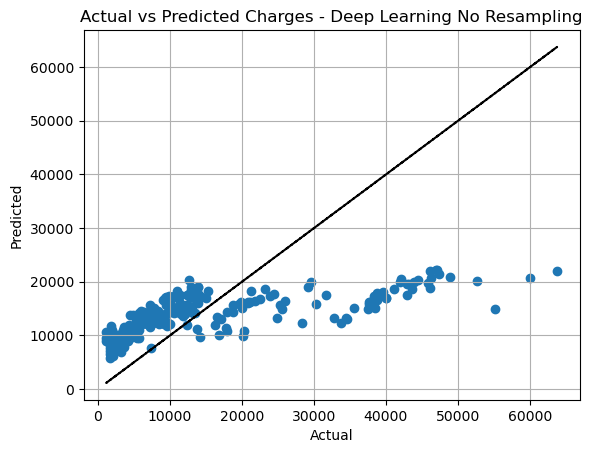

In [109]:
# Scatter plot showing Actual vs Predicted
plt.scatter(y_test, y_pred1)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Deep Learning No Resampling')
plt.grid()
plt.show()

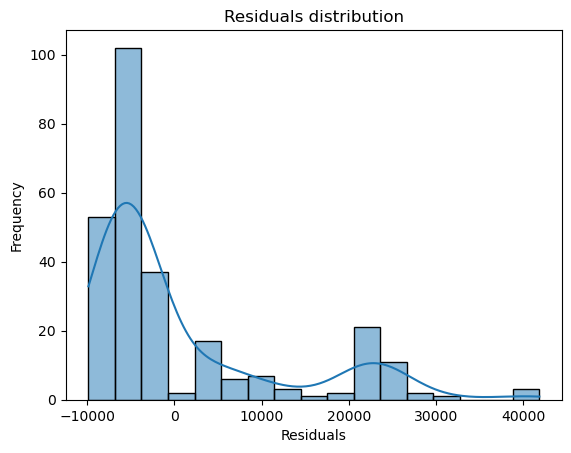

In [110]:
# Visualize residuals
residuals = y_test - y_pred1.ravel()

sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()

### Bootstrapped

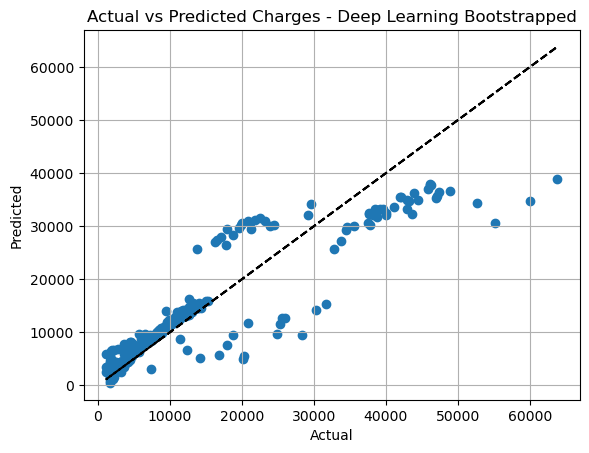

In [112]:
# Scatter plot showing Actual vs Predicted
plt.scatter(y_test, y_pred2)
plt.plot(y_test, y_test, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Charges - Deep Learning Bootstrapped')
plt.grid()
plt.show()

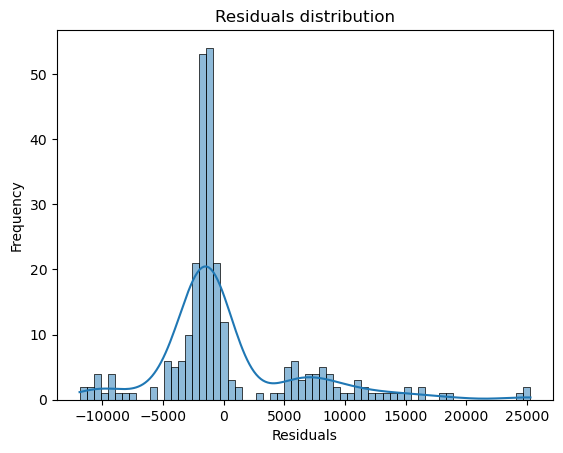

In [113]:
# Visualize residuals
residuals = y_test - y_pred2.ravel()
sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.show()